<a href="https://colab.research.google.com/github/casualcomputer/AgPal/blob/main/AgPal_optimize_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (Python libraries)

## Set "requirements.txt"

In [1]:
%%writefile requirements.txt
beautifulsoup4==4.11.1
gensim==4.2.0
nltk==3.7
numpy==1.21.5
pandas==1.4.4
scipy==1.9.1
tqdm==4.64.1
seaborn==0.12.1
sentence-transformers==2.2.2
faiss-gpu==1.7.2
sentence-transformers==2.2.2
faiss-gpu==1.7.2

Writing requirements.txt


## Install packages

In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 16.0 MB/s 
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
     |████████████████████████████████| 15.7 MB 24 kB/s 
     |████████████████████████████████| 11.7 MB 9.4 MB/s 
     |████████████████████████████████| 43.4 MB 1.2 MB/s 
     |████████████████████████████████| 288 kB 46.8 MB/s 
     |████████████████████████████████| 85 kB 2.0 MB/s 
     |████████████████████████████████| 85.5 MB 101 kB/s 
     |████████████████████████████████| 5.8 MB 54.0 MB/s 
     |████████████████████████████████| 1.3 MB 51.9 MB/s 
     |████████████████████████████████| 182 kB 57.0 MB/s 
     |████████████████████████████████| 7.6 MB 32.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e76dcb8a928f7581f61d78573685c16dea0388b304e6fbe487832c412b7be95c
  Stored in directory: /roo

# Get dataset

## Get data dump with API

In [3]:
import requests
import pandas as pd
path ="http://api.agpaldataservice.ca/AgPalDataAPI/api/v2/query?format=xml&type=file"
data = pd.read_xml(path)
data.desc = data.desc.fillna('None')
data.head()

,docType,title,id,url,authority,programOwner,shortDesc,desc,policyFramework,category,region,topic,service,commodity,clientType,programStatus,createdDate,modifiedDate,publishedDate
0,program,AgriInsurance,AAFC-004-en,"<a target=""_blank"" href=""https://agriculture.c...",Federal,AAFC,<p>AgriInsurance is a federal-provincial-produ...,<p>AgriInsurance is a federal-provincial-produ...,CanadianAgriculturalPartnership,Service,AcrossCanada,InsuranceRecoveryAid,InsuranceRecoveryAid,BeesApiculture,FarmersFoodProducers,open,2012-01-27,2021-10-08,2021-10-08
1,program,Canadian Agricultural Loans Act (CALA) Program,AAFC-006-en,"<a target=""_blank"" href=""https://agriculture.c...",Federal,AAFC,<p>The Canadian Agricultural Loans Act (CALA) ...,<p>The CALA program builds on and replaces the...,NotApplicable,Program,AcrossCanada,EquipmentMachineryProcessing,FinancialSupportIncentives,Nonspecific,YoungFarmersNewEntrants,open,2012-01-27,2021-10-08,2021-10-08
2,program,Farm Debt Mediation Service (FDMS),AAFC-008-en,"<a target=""_blank"" href=""https://agriculture.c...",Federal,AAFC,<p>The Farm Debt Mediation Service offers fina...,<p>The Farm Debt Mediation Service offers fina...,NotApplicable,Service,AcrossCanada,ExpertiseAdviceGuidance,ExpertiseAdviceGuidance,Nonspecific,FarmersFoodProducers,open,2012-01-27,2021-10-08,2021-10-08
3,program,Managing Agroclimate Risk,AAFC-0161-en,"<a target=""_blank"" href=""https://agriculture.c...",Federal,AAFC,<p>The information here on farm management pra...,None,NotApplicable,GuidesInformation,AcrossCanada,LandPurchaseLeasingAccess,LandInfrastructure,Livestock,NonprofitCommunityOrganizations,open,2018-02-06,2020-04-15,2020-04-15
4,program,Watershed Protection,AAFC-0164-en,"<a target=""_blank"" href=""https://agriculture.c...",Federal,AAFC,<p>Provides information on the basics of water...,None,NotApplicable,GuidesInformation,AcrossCanada,ExpertiseAdviceGuidance,LandInfrastructure,Nonspecific,NonprofitCommunityOrganizations,open,2018-02-09,2021-01-15,2021-01-15


## Extract url

In [4]:
from bs4 import BeautifulSoup

extracted_url = []

# The HTML string to be cleaned
for html_string in data.url:

  # Create a BeautifulSoup object
  soup = BeautifulSoup(html_string, 'html.parser')

  # Find all 'a' elements (which represent hyperlinks)
  links = soup.find_all('a')

  # Extract the 'href' attribute from each element
  for link in links:
      href = link['href']
      extracted_url.append(href)

data.url = extracted_url

## Remove html tags

In [5]:
import re
import numpy as np 

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

data['shortDesc']=data['shortDesc'].apply(lambda cw : remove_tags(cw))
data['desc'] = data['desc'].astype(str).apply(lambda cw : remove_tags(cw))

import numpy as np
data['desc_new']= np.where(data['desc']!='None', data['desc'], data['shortDesc'])

data.head()

,docType,title,id,url,authority,programOwner,shortDesc,desc,policyFramework,category,region,topic,service,commodity,clientType,programStatus,createdDate,modifiedDate,publishedDate,desc_new
0,program,AgriInsurance,AAFC-004-en,https://agriculture.canada.ca/en/agricultural-...,Federal,AAFC,AgriInsurance is a federal-provincial-producer...,AgriInsurance is a federal-provincial-producer...,CanadianAgriculturalPartnership,Service,AcrossCanada,InsuranceRecoveryAid,InsuranceRecoveryAid,BeesApiculture,FarmersFoodProducers,open,2012-01-27,2021-10-08,2021-10-08,AgriInsurance is a federal-provincial-producer...
1,program,Canadian Agricultural Loans Act (CALA) Program,AAFC-006-en,https://agriculture.canada.ca/en/agricultural-...,Federal,AAFC,The Canadian Agricultural Loans Act (CALA) Pro...,The CALA program builds on and replaces the fo...,NotApplicable,Program,AcrossCanada,EquipmentMachineryProcessing,FinancialSupportIncentives,Nonspecific,YoungFarmersNewEntrants,open,2012-01-27,2021-10-08,2021-10-08,The CALA program builds on and replaces the fo...
2,program,Farm Debt Mediation Service (FDMS),AAFC-008-en,https://agriculture.canada.ca/en/agricultural-...,Federal,AAFC,The Farm Debt Mediation Service offers financi...,The Farm Debt Mediation Service offers financi...,NotApplicable,Service,AcrossCanada,ExpertiseAdviceGuidance,ExpertiseAdviceGuidance,Nonspecific,FarmersFoodProducers,open,2012-01-27,2021-10-08,2021-10-08,The Farm Debt Mediation Service offers financi...
3,program,Managing Agroclimate Risk,AAFC-0161-en,https://agriculture.canada.ca/en/agriculture-a...,Federal,AAFC,The information here on farm management practi...,None,NotApplicable,GuidesInformation,AcrossCanada,LandPurchaseLeasingAccess,LandInfrastructure,Livestock,NonprofitCommunityOrganizations,open,2018-02-06,2020-04-15,2020-04-15,The information here on farm management practi...
4,program,Watershed Protection,AAFC-0164-en,https://agriculture.canada.ca/en/agriculture-a...,Federal,AAFC,Provides information on the basics of watershe...,None,NotApplicable,GuidesInformation,AcrossCanada,ExpertiseAdviceGuidance,LandInfrastructure,Nonspecific,NonprofitCommunityOrganizations,open,2018-02-09,2021-01-15,2021-01-15,Provides information on the basics of watershe...


## Remove stop words

In [6]:
import nltk
# Get stop words
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Get stop words 
en_stop = set(nltk.corpus.stopwords.words('english'))
print(en_stop)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


{'very', 'their', 'does', 'out', 'most', "you'd", 'but', 'by', 'are', 'isn', 'through', 'couldn', 'my', 'above', 'ma', 'of', 'i', 'can', "don't", 'only', 'you', 'an', 'off', 'needn', 'mustn', 'who', "didn't", 'yourselves', 'ain', 'no', 'her', 'herself', 'then', 'now', 'should', "aren't", 'all', 'so', 'than', "you'll", "that'll", 'haven', 'hers', 'there', 'didn', 'too', 'hasn', 'again', "wouldn't", 'other', 'not', "doesn't", 'just', 'wouldn', 'before', "she's", 'because', 't', 'will', 'she', 'yours', 'shouldn', 'against', 'am', "shan't", 'up', "you've", 'while', 'down', 'doing', 'weren', 'if', "needn't", 'where', 'were', "mightn't", 'aren', 'doesn', 'or', "mustn't", 'himself', 'few', 'be', 'mightn', 'as', 'any', 'during', "isn't", 'your', 'being', 'under', "should've", 'ourselves', "it's", 'is', 'each', 'themselves', 'o', 'both', 've', 'this', 'more', 'had', 'here', 'own', 'itself', 'between', 'they', 'after', 'on', 'he', 'd', 'with', 'whom', 'until', "wasn't", 'which', 'did', 'at', 'in

## Preprocessing pipeline

In [7]:
"""
Data pre-processing
"""

# Lemmatization
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

# Text cleaning function for gensim fastText word embeddings in python
def process_text(document):
     
        # Remove extra white space from text
        document = re.sub(r'\s+', ' ', document, flags=re.I)
         
        # Remove all the special characters from text
        document = re.sub(r'\W', ' ', str(document))
 
        # Remove all single characters from text
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
 
        # Converting to Lowercase
        document = document.lower()
 
        # Word tokenization       
        tokens = document.split()

        # Lemmatization using NLTK
        lemma_txt = [stemmer.lemmatize(word) for word in tokens]
        
        # Remove stop words
        lemma_no_stop_txt = [word for word in lemma_txt if word not in en_stop]
        
        # Drop words 
        tokens = [word for word in tokens if len(word) > 3]
                 
        clean_txt = ' '.join(lemma_no_stop_txt)
 
        return clean_txt
    
some_sent = data.desc_new

from tqdm import tqdm
print(tqdm(some_sent))

clean_corpus = [process_text(sentence) for sentence in tqdm(some_sent) if sentence.strip() !='']
clean_corpus_lst = [d.split() for d in clean_corpus]
 
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]

#print("\n\nword_tokens: ",word_tokens)
#print("\nclean_corpus_lst: ",clean_corpus_lst)

  0%|          | 0/3119 [00:00<?, ?it/s]


  0%|          | 0/3119 [00:00<?, ?it/s]


100%|██████████| 3119/3119 [00:00<00:00, 193001.60it/s]


# Modelling (SBERT for asymmetric semantic search -> PCA -> K-MEANS || TSNE for visualization)

## S-BERT + cosine-similarity



*   https://www.sbert.net/examples/applications/semantic-search/README.html
*   https://www.sbert.net/docs/pretrained-models/msmarco-v3.html
*   https://www.sbert.net/examples/applications/retrieve_rerank/README.html
*   https://arxiv.org/abs/2010.08240

In [8]:
import torch
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('msmarco-distilbert-base-tas-b') #msmarco-distilbert-cos-v5
# model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

query_string = "quebec funding cow breeding"
query_embedding = model.encode(query_string)
passage_embedding = model.encode(clean_corpus_lst) #encode first

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [11]:
data['sbert_scores'] = torch.cat([util.cos_sim(query_embedding, doc) for doc in passage_embedding]).numpy()
data.sort_values(by=['sbert_scores'], ascending=False)[["id","topic", "title","desc_new","sbert_scores"]]

,id,topic,title,desc_new,sbert_scores
1113,CFIA-10001-en,ExpertiseAdviceGuidance,Food Safety Recognition Program,The Canadian On-Farm Food Safety Program provi...,0.827009
1138,CFLC-001-en,ExpertiseAdviceGuidance,The Canadian Farm Learning Centre,The Canadian Farm Learning Centre is an online...,0.827009
1500,MAPAQ-10022-en,FinancingCreditIncomeStability,Quebec Fisheries Fund,The Quebec Fisheries Fund will stimulate innov...,0.820208
484,ASSN-10037-en,ExpertiseAdviceGuidance,Canadian Livestock Genetics Association,The Canadian Livestock Genetics Association is...,0.817308
961,ASSN-10617-en,ExpertiseAdviceGuidance,Quebec Grain Producers,Quebec Grain Producers represents the interest...,0.808751
...,...,...,...,...,...
376,ABARD-447-en,DataMapsTools,Manure Transportation Calculator,The calculator determines the net cost of appl...,0.583753
2313,ONAFR-10387-en,AnimalHealthWelfareGenetics,Fibre Digestibility &amp; Forage Quality,Accurately estimating Net Energy and Total Dig...,0.581640
14,AAFC-035-en,PromotionalEventsSupport,Single Window Contact for Agri-Food Trade Serv...,Get in touch with us via email for export-rela...,0.581361
2066,ONAFR-10139-en,FarmingMethodsPractices,Relative Value of Feedstuffs for Swine Worksheet,The relative value of feedstuffs worksheet is ...,0.579909


## S-BERT (util.semantic_search); same as before

*   https://towardsdatascience.com/advance-nlp-model-via-transferring-knowledge-from-cross-encoders-to-bi-encoders-3e0fc564f554
*   https://medium.com/@adriensieg/text-similarities-da019229c894

In [12]:
from sentence_transformers import SentenceTransformer, util

queries = ["quebec funding cow breeding","ontario flood"]
embedder = SentenceTransformer('all-MiniLM-L6-v2')

corpus_embeddings = embedder.encode(clean_corpus_lst, convert_to_tensor=True)
corpus_embeddings = corpus_embeddings.to('cuda')
corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

query_embeddings = embedder.encode(queries, convert_to_tensor=True)
query_embeddings = query_embeddings.to('cuda')
query_embeddings = util.normalize_embeddings(query_embeddings)
hits = util.semantic_search(query_embeddings, corpus_embeddings, score_function=util.dot_score)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [13]:
def relevant_results(query_index):
  return data.loc[pd.DataFrame(hits[query_index])['corpus_id'].to_numpy(),]
#relevant_results(0) #print out top search

In [14]:
def relevant_search_index(hits,query_index):
  index = pd.DataFrame(hits[query_index])['corpus_id'].to_numpy()

relevant_indices = relevant_search_index(hits,1)
#print(relevant_indices)

## S-BERT + KNN (faiss)

* General: https://medium.com/mlearning-ai/semantic-search-with-s-bert-is-all-you-need-951bc710e160

* Tuning tutorial: https://www.kaggle.com/code/mateiionita/taming-the-bert-a-baseline/notebook

* Next steps: SBERT + DNN for supervised/unsupervised learning? 

In [15]:
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [16]:
#https://www.kaggle.com/code/sbrvrm/semantic-search-with-sbert-faiss
import faiss

encoded_data = model.encode(clean_corpus_lst)
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(clean_corpus_lst))))
faiss.write_index(index, 'agpal_listing.index')

In [17]:
import time
def fetch_agpal_info(df,dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['id'] = info['id']
    meta_dict['topic'] = info['topic']
    meta_dict['title'] = info['title']
    meta_dict['desc_new'] = info['desc_new']
    return meta_dict
 
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_agpal_info(data,idx) for idx in top_k_ids]
    return results

In [18]:
#https://www.kaggle.com/code/sbrvrm/semantic-search-with-sbert-faiss
from pprint import pprint
import time 

query="quebec funding cow breeding"
results=search(query, top_k=10, index=index, model=model)

#print("\n")
#for result in results:
#    print('\t',result)

results =  pd.DataFrame(results)
#results #fetch top searches

>>>> Results in Total Time: 0.03373861312866211


## PCA

In [19]:
from sklearn.decomposition import PCA
X= encoded_data
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X)
X_reduced.shape

(3119, 184)

## PCA (ELBOW)

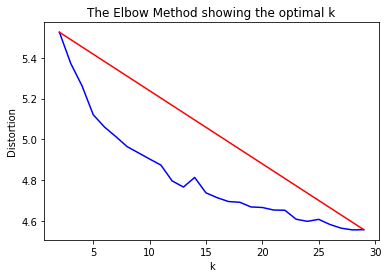

In [20]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

#choose optimal number of clusters
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
data['y']= y_pred
centers = np.array(kmeans.cluster_centers_)

## TSNE

In [22]:
#save SBERT
#https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=50,random_state=1099)  # Changed perplexity from 100 to 50  
X_embedded = tsne.fit_transform(encoded_data)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3119 samples in 0.003s...
[t-SNE] Computed neighbors for 3119 samples in 0.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3119
[t-SNE] Computed conditional probabilities for sample 2000 / 3119
[t-SNE] Computed conditional probabilities for sample 3000 / 3119
[t-SNE] Computed conditional probabilities for sample 3119 / 3119
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.308212
[t-SNE] KL divergence after 1000 iterations: 1.400443


# Plot graphs

## Plot TSNE

<ipython-input-23-66b038e16c55>:12: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.scatterplot(df,x='x',y='y',hue=y_pred,legend='full', palette=palette)


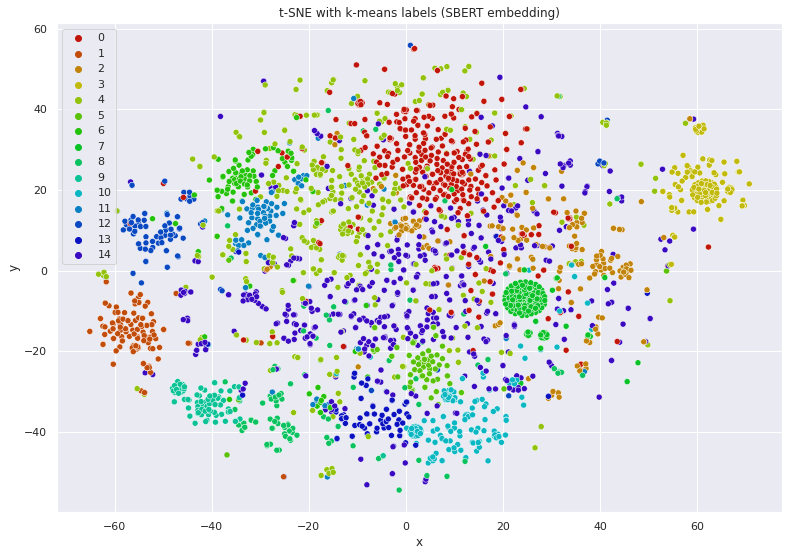

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
df = pd.DataFrame(X_embedded, columns = ['x','y'])
sns.scatterplot(df,x='x',y='y',hue=y_pred,legend='full', palette=palette)
plt.title('t-SNE with k-means labels (SBERT embedding)')
#plt.savefig("t-sne_agpal.png")
plt.show()

## Culmulative frequency for all tags

In [24]:
df1= pd.DataFrame(data['topic'].value_counts())#.plot.pie(rotatelabels=False,autopct='%1.0f%%',pctdistance=0.6, labeldistance=0.7)
df1['CumulativePercent'] = 100*(df1.topic.cumsum() / df1.topic.sum())
num_post_categories = df1.shape[0]
print(f"There are {num_post_categories} unique tags for all agpal posts.")
df1

There are 34 unique tags for all agpal posts.


,topic,CumulativePercent
ExpertiseAdviceGuidance,1099,35.235652
FinancingCreditIncomeStability,362,46.841937
CropProduction,275,55.658865
DataMapsTools,153,60.564283
PestManagement,133,64.828471
RegulationsEnforcement,115,68.515550
LandPurchaseLeasingAccess,102,71.785829
LeadershipTrainingWorkforceDevelopment,97,74.895800
LaboratoryVeterinaryServices,78,77.396601
ProductDevelopmentCommercialization,56,79.192049


## Plot distribution of tags for each cluster

In [25]:
f = plt.figure()
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(r'tagsByClusters.pdf') as export_pdf:
  for cluster_index in sorted(data['y'].unique()):
    cluster_data = data[data["y"] == cluster_index]['topic']
    num_rows = cluster_data.shape[0]
    top_topics = cluster_data.value_counts().head(5)
    capture_rate = sum(top_topics.to_frame().reset_index()["topic"])/num_rows
    plot_title = "Cluster " + str(cluster_index)+": "+f' the top 5 topics account for {capture_rate:.0%} percent of all posts in the cluster'
    top_topics.plot.pie(rotatelabels=False,autopct='%1.0f%%',pctdistance=0.6, labeldistance=0.7)
    plt.xlabel(plot_title, rotation=0)
    # print("--------------------------------------------------------------------------\n")
    # plt.show()
    export_pdf.savefig()
    plt.close()
  f.savefig("tags per cluster.pdf", bbox_inches='tight')

# API for AgPal

In [ ]:
params = {'lang': 'EN', 'format': 'json',"keyword":"quebec stuff","pagesize":10,"page":1}
url = "http://api.agpaldataservice.ca/AgPalDataAPI/api/v2/query"
url2 = "https://agpal.ca/en/search-agpal"
response=requests.get(url, params=params)

In [ ]:
# https://curlconverter.com/
# https://www.convertcsv.com/json-to-csv.htm
import requests

headers = {
    'authority': 'prodapi.agpal.ca',
    'accept': 'application/json, text/plain, */*',
    'accept-language': 'en-US,en;q=0.9,zh-TW;q=0.8,zh;q=0.7',
    'content-type': 'multipart/form-data; boundary=----WebKitFormBoundarybyu7xBgCXVoSYsl8',
    'origin': 'https://agpal.ca',
    'referer': 'https://agpal.ca/',
    'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Microsoft Edge";v="108"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.42',
}

data = '------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="queryaction"\r\n\r\nfieldquery\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="fq"\r\n\r\nkeyword:{toronto}\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="lang"\r\n\r\nen\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="pageSize"\r\n\r\n25\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="sort"\r\n\r\nscore:desc\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8\r\nContent-Disposition: form-data; name="sort"\r\n\r\nsort2:asc\r\n------WebKitFormBoundarybyu7xBgCXVoSYsl8--\r\n'

response = requests.post('https://prodapi.agpal.ca/api/v1/search', headers=headers, data=data)
response.text

'{"count":"27","docs":[{"ID":"ASSN-10177-en","shortDesc":"\\n         <p>Promotes a collaborative approach to Canadian animal health.</p>\\n      ","title":"Canadian Animal Health Coalition","url":"\\n         <a target=\\"_blank\\" href=\\"https://animalhealth.ca/\\">Canadian Animal Health Coalition</a>\\n      ","authority":"Other","programOwner":"ASSN","policyFramework":"NotApplicable","releaseStatus":"live","programOwnerNotes":"","rank":"18175.977","category":"Service","region":["AcrossCanada"],"topic":["AnimalHealthWelfareGenetics","ExpertiseAdviceGuidance"],"service":["ExpertiseAdviceGuidance"],"commodity":["PoultryEggs","Livestock"],"clientType":["AgribusinessesFoodProcessors","IndustryAssociationsFarmingOrganizations","FarmersFoodProducers","Veterinarians","EquineBusinesses"],"keywords":["on n0m 1t0 grand bend box 1314 info@animalhealth.ca 519.835.2233 canadian carl block award cahc 2013 novemb 26, 2019 agm, ottawa 2013 12:00 pm edt novemb 26, 2019 octob 23, 2019 toronto 19, 20

In [ ]:
import requests

cookies = {
    'visid_incap_2269415': 'qxLOSaZ6Shqe0TQvFj2OK0/KjmMAAAAAQUIPAAAAAACMP5xXb6J2MevqZKGBXQ1H',
    'nlbi_2269415': 'gNVMHDV3cn1iABDYzBLR3QAAAAC6E9kQPw2K9B5qXQrNyvc5',
    'incap_ses_674_2269415': 'yRbyH87CeA65otwRRIhaCVDKjmMAAAAAHz1EgifEf/xyN90x0WX9XA==',
    'reese84': '3:hNK4DVcvfopUMKFF+59dYw==:HckW2RwNAYCtg94XYRRfxLZ167RXNW/MYgi6TpIPNCKOlt3KcYDra/0oU5YJjdlT/5BGadfhhTHKYw4pw8LzmIu/0UYMn5On12kSMAB78EhtNmdekwIUZs5cO2Kt6pz01U59IYwlD1Al9J2N4BwNmYK0OAaCrVoXU/9OOimehxyyHMMfaRZJJq4x25KPSpG2UhL3Untq2QjJFEZlktLjYyEhpHjkMxH88/2AorFhWwiaW0JFeB6Tywiwx0jgJtiBvp4TrIN+W9JHjHmEq8U7lVOlJyidgtjXjqtbazRuy5UdorrfbmOepssj2sbtU2QNuhvvrggRMLAIKY+plIj0HUTlAOKeXrG9D9e7RWERmJMGmlOV9KrfzJTKlOxGLXK1hGuiW5LWKnSArVJeFodZxw+dgKq4U+TOdMET5eo5lxAgN8ej1ZZJxM7i6pfH6Q18/ogiiffeazBwusya9q822A==:OzBrhj6/QyGrej87w5OrfQMV9OSnmhQF6yxSGiv9xNI=',
    'gig_bootstrap_3_mrQiIl6ov44s2X3j6NGWVZ9SDDtplqV7WgdcyEpGYnYxl7ygDWPQHqQqtpSiUfko': 'gigya-pr_ver4',
    'ASP.NET_SessionId': 'oypqnqdplwlv30e1fcjkjeqi',
    'visid_incap_2271082': 'wSUcntjMQ/qqeKjPgooVmljKjmMAAAAAQUIPAAAAAABnJXWAWosbcgIP38noPGby',
    'nlbi_2271082': 'ijZpUZzCsRKAzXTcVPrQ3QAAAAAp+aG/k5zGtSruGY3nkybj',
    'incap_ses_674_2271082': 'ZNGxQMmeNTDDptwRRIhaCVrKjmMAAAAArOI9oBEeNWNl2vNNlcKstw==',
    'nlbi_2269415_2147483392': 'QDHjLQS88QJ1HQOLzBLR3QAAAABJVrq/cD7Vkja1W136cfS4',
}

headers = {
    'authority': 'api2.realtor.ca',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9,zh-TW;q=0.8,zh;q=0.7',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    # 'cookie': 'visid_incap_2269415=qxLOSaZ6Shqe0TQvFj2OK0/KjmMAAAAAQUIPAAAAAACMP5xXb6J2MevqZKGBXQ1H; nlbi_2269415=gNVMHDV3cn1iABDYzBLR3QAAAAC6E9kQPw2K9B5qXQrNyvc5; incap_ses_674_2269415=yRbyH87CeA65otwRRIhaCVDKjmMAAAAAHz1EgifEf/xyN90x0WX9XA==; reese84=3:hNK4DVcvfopUMKFF+59dYw==:HckW2RwNAYCtg94XYRRfxLZ167RXNW/MYgi6TpIPNCKOlt3KcYDra/0oU5YJjdlT/5BGadfhhTHKYw4pw8LzmIu/0UYMn5On12kSMAB78EhtNmdekwIUZs5cO2Kt6pz01U59IYwlD1Al9J2N4BwNmYK0OAaCrVoXU/9OOimehxyyHMMfaRZJJq4x25KPSpG2UhL3Untq2QjJFEZlktLjYyEhpHjkMxH88/2AorFhWwiaW0JFeB6Tywiwx0jgJtiBvp4TrIN+W9JHjHmEq8U7lVOlJyidgtjXjqtbazRuy5UdorrfbmOepssj2sbtU2QNuhvvrggRMLAIKY+plIj0HUTlAOKeXrG9D9e7RWERmJMGmlOV9KrfzJTKlOxGLXK1hGuiW5LWKnSArVJeFodZxw+dgKq4U+TOdMET5eo5lxAgN8ej1ZZJxM7i6pfH6Q18/ogiiffeazBwusya9q822A==:OzBrhj6/QyGrej87w5OrfQMV9OSnmhQF6yxSGiv9xNI=; gig_bootstrap_3_mrQiIl6ov44s2X3j6NGWVZ9SDDtplqV7WgdcyEpGYnYxl7ygDWPQHqQqtpSiUfko=gigya-pr_ver4; ASP.NET_SessionId=oypqnqdplwlv30e1fcjkjeqi; visid_incap_2271082=wSUcntjMQ/qqeKjPgooVmljKjmMAAAAAQUIPAAAAAABnJXWAWosbcgIP38noPGby; nlbi_2271082=ijZpUZzCsRKAzXTcVPrQ3QAAAAAp+aG/k5zGtSruGY3nkybj; incap_ses_674_2271082=ZNGxQMmeNTDDptwRRIhaCVrKjmMAAAAArOI9oBEeNWNl2vNNlcKstw==; nlbi_2269415_2147483392=QDHjLQS88QJ1HQOLzBLR3QAAAABJVrq/cD7Vkja1W136cfS4',
    'origin': 'https://www.realtor.ca',
    'referer': 'https://www.realtor.ca/',
    'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Microsoft Edge";v="108"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.42',
}

data = {
    'LatitudeMax': '45.59912',
    'LongitudeMax': '-75.34509',
    'LatitudeMin': '45.37187',
    'LongitudeMin': '-75.90876',
    'Sort': '6-D',
    'PropertyTypeGroupID': '1',
    'PropertySearchTypeId': '1',
    'TransactionTypeId': '2',
    'Currency': 'CAD',
    'RecordsPerPage': '12',
    'ApplicationId': '1',
    'CultureId': '1',
    'Version': '7.0',
    'CurrentPage': '1',
}

response2 = requests.post('https://api2.realtor.ca/Listing.svc/PropertySearch_Post', cookies=cookies, headers=headers, data=data)
response2.text

'{"ErrorCode":{"Id":200,"Description":"Success - OK","Status":"Pins-Via-Cache:false;Sidebar-Items-Via-Cache:0;","ProductName":"Realtor API 7 | 20221109.3 | 660facef3b43c5755e5e5919321dc8bda7be3159 | Wednesday, November 9, 2022 10:42:45 AM","Version":"1.0.8348.28292"},"Paging":{"RecordsPerPage":12,"CurrentPage":1,"TotalRecords":2054,"MaxRecords":600,"TotalPages":50,"RecordsShowing":600,"Pins":950},"Results":[{"Id":"25118125","MlsNumber":"23738537","PublicRemarks":"Directly on the Plateau, this superb 2019 construction is offering you 3 bedrooms upstairs, 2 bathrooms and a powder room, kitchen with thermoplastic cabinets and a large family room. Close to all services, it awaits you! (48856662)","Building":{"BathroomTotal":"1","Bedrooms":"3","StoriesTotal":"2","Type":"House"},"Individual":[{"IndividualID":2093839,"Name":"Souleymane Haydara","Organization":{"OrganizationID":57109,"Name":"RE\\/MAX DIRECT INC.","Logo":"https:\\/\\/cdn.realtor.ca\\/organization\\/en-CA\\/TS638058681320000000\

# Download files

In [ ]:
df1.to_csv('df1.csv') 
from google.colab import files
files.download("df1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# make an example object to pickle
with open('X_embedded_desc_new.p', 'wb') as f:
    pickle.dump(X_embedded, f)